## Introduction
This notebook present the performances of the GaussianMixture class using a cholesky decomposition of the precision matrix.

In [1]:
%matplotlib inline

# To keep track of the machine this script is run in
import IPython; 
import platform;
import sklearn, numpy as np, scipy
from ast import literal_eval

CURR_IPYTHON_VERSION = IPython.__version__
PYTHON_INPT = literal_eval(IPython.sys_info())['sys_executable']
SKVERSION = sklearn.__version__; SCVERSION = scipy.__version__; NPVERSION = np.__version__
print("Running on %s" % platform.platform())
!echo -e "At host \"$(hostname)\" with $(nproc) cores. Current Dir - $(pwd)\n"
!echo -n "sklearn $SKVERSION "
print("@ %s\n" % str(sklearn.__path__))
!echo -e -n "np v$NPVERSION - scipy v$SCVERSION \nIPython v$CURR_IPYTHON_VERSION - "
!echo -n "$($PYTHON_INPT --version)"
!echo "@ $PYTHON_INPT"

Running on Linux-3.19.0-58-generic-x86_64-with-debian-jessie-sid
-e At host "caprica" with 4 cores. Current Dir - /home/zloten/Documents/sklearn-notebook/Benchmarks

sklearn 0.18.dev0 @ ['/home/zloten/Documents/scikit-learn/sklearn']

-e -n np v1.11.0 - scipy v0.17.0 
IPython v4.1.1 - 
Python 3.5.1 :: Continuum Analytics, Inc.
@ /home/zloten/anaconda3/envs/sklearn/bin/python


## Resulting Plots
A figure to visualy check the plot result of the different GaussianMixture fittings.

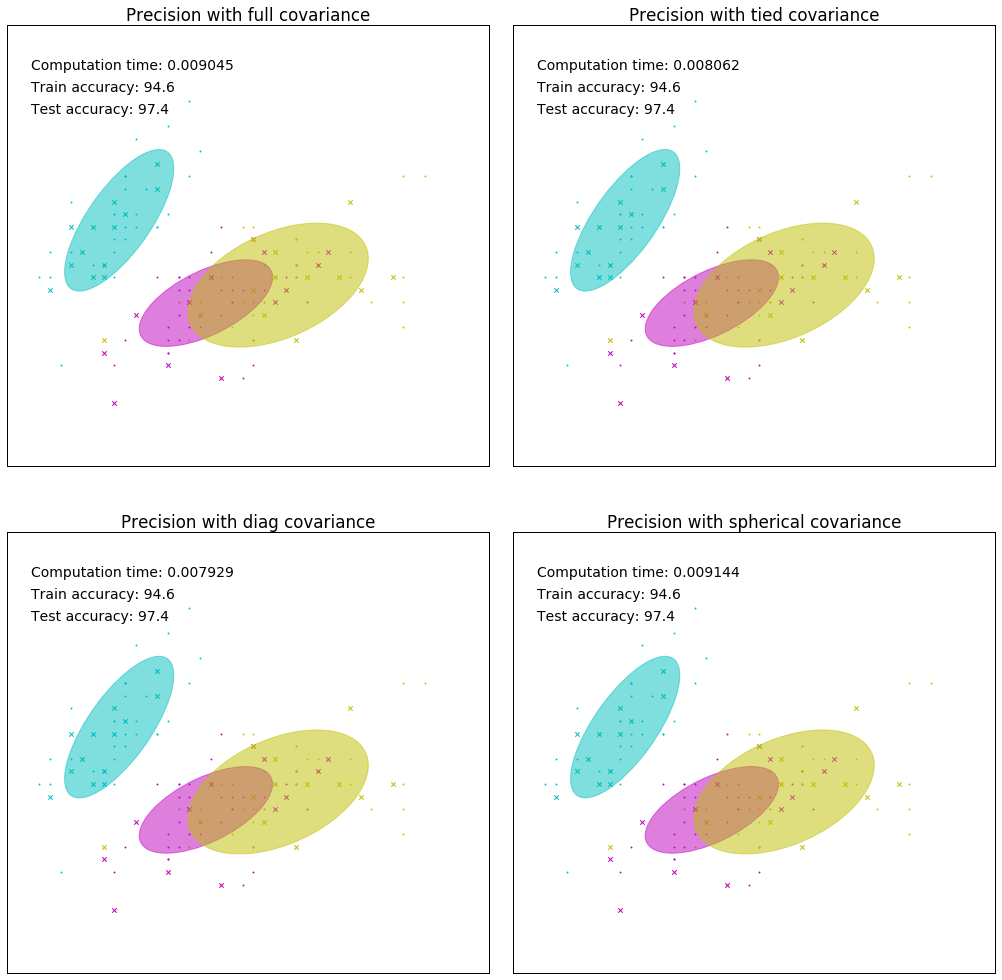

In [3]:
from time import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as linalg
from sklearn.mixture import GaussianMixture
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from utils import *

plt.rcParams['figure.figsize'][:] = [14, 14]
plt.rcParams['font.size'] = 14.
plt.rcParams['axes.labelsize'] = 'large'

iris = datasets.load_iris()
skf = StratifiedKFold(n_folds=4)
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))

X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

means_init = np.array([X_train[y_train == i].mean(axis=0) for i in range(len(np.unique(y_train)))])
gmm = GaussianMixture(n_components=len(np.unique(y_train)), random_state=0, means_init=means_init)

plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05, left=.01, right=.99)
for index, cov_type in enumerate(['full', 'tied', 'diag', 'spherical']):
    gmm.precision_type = cov_type
    
    computation_time = time()
    gmm.fit(X_train)
    computation_time = time() - computation_time
    
    h = plt.subplot(2, 2, index + 1)
    plot_ellipses(gmm.means_, gmm.covariances_, gmm.covariance_type, h) 
    plt.text(0.05, 0.9, 'Computation time: %f' % computation_time, transform=h.transAxes)

    for n in range(gmm.n_components):
        data = X_train[y_train == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=colors[n],
                label=iris.target_names[n])
    # Plot the test data with crosses
    for n in range(gmm.n_components):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=colors[n])

    y_train_pred = gmm.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.85, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = gmm.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title('Precision with %s covariance' % cov_type)
        
plt.show()

In [4]:
n_components, n_samples, n_features = 3, 100000, 10

rng = np.random.RandomState(0)

X = rng.rand(n_samples, n_features)

gmm = GaussianMixture(n_components=n_components)

In [5]:
def test_fit(gmm, X):
    for _ in range(10):
        gmm.fit(X)
        
%lprun -f GaussianMixture.fit test_fit(gmm, X)

In [7]:
from sklearn.mixture.gaussian_mixture import _estimate_log_gaussian_prob_full

def test_score_samples(gmm, X):
    for _ in range(10):
        gmm.score_samples(X)
        
%lprun -f _estimate_log_gaussian_prob_full test_score_samples(gmm, X)